#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.





* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 : 
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 : 
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
data = pd.read_csv('/content/drive/MyDrive/2023/AIVLE/miniproject5/2023.04.12_미니프로젝트5차_3_5일차 실습자료/data01_train.csv')
features = pd.read_csv('/content/drive/MyDrive/2023/AIVLE/miniproject5/2023.04.12_미니프로젝트5차_3_5일차 실습자료/features.csv')

In [21]:
data = data.drop(['subject'], axis = 1)

In [15]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [16]:
X = data.drop(['Activity'], axis = 1) #'subject'
y = data['Activity']

In [17]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [22]:
gr_mu = data.groupby('Activity').mean().iloc[:, 1 :]
gr_mu

,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
Activity,,,,,,,,,,,,,,,,,,,,,
LAYING,-0.018417,-0.107785,-0.960691,-0.937412,-0.942267,-0.963064,-0.937771,-0.941047,-0.909996,-0.539015,...,0.160376,-0.354266,-0.665671,0.014092,0.015730,0.020949,-0.001137,0.515353,-0.442074,-0.442538
SITTING,-0.012072,-0.106352,-0.983166,-0.937754,-0.940105,-0.985014,-0.937914,-0.937808,-0.926686,-0.532022,...,0.175852,-0.376696,-0.678580,0.014437,0.000735,0.011727,-0.031514,-0.690639,-0.005482,-0.096410
STANDING,-0.016679,-0.107184,-0.985546,-0.937629,-0.943353,-0.988146,-0.938838,-0.941242,-0.922856,-0.534654,...,0.102096,-0.357825,-0.665034,0.007544,0.014301,0.005826,0.022757,-0.772145,0.210669,0.043542
WALKING,-0.017413,-0.109834,-0.308924,-0.019184,-0.245919,-0.346738,-0.053647,-0.249090,-0.100020,-0.053908,...,0.120874,-0.062677,-0.393210,0.026759,-0.015779,-0.004320,-0.016623,-0.757127,0.219866,0.067278
WALKING_DOWNSTAIRS,-0.016740,-0.105793,0.137657,0.073628,-0.172184,0.071761,0.018639,-0.194114,0.439378,0.022434,...,0.096655,-0.321526,-0.665569,-0.054241,-0.032976,0.176974,-0.066018,-0.779684,0.197577,0.057130
WALKING_UPSTAIRS,-0.026729,-0.120764,-0.222087,-0.005984,-0.145224,-0.280200,-0.023569,-0.137355,-0.012986,-0.034906,...,0.091210,-0.360494,-0.679241,0.032069,0.001185,-0.142824,0.042089,-0.630221,0.282750,0.130762


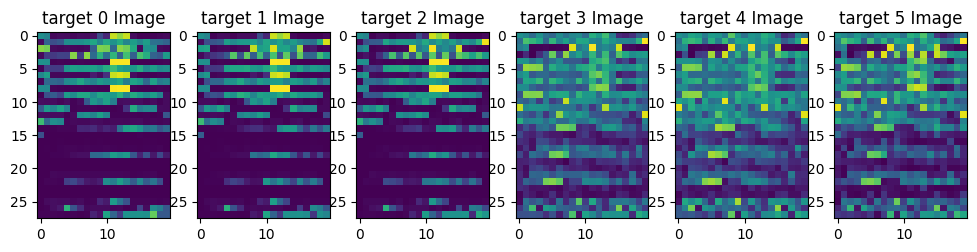

In [24]:
f, a = plt.subplots(1, 6, figsize = (12, 6))
for i in range(6) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu.iloc[i]).reshape(28, 20))

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [25]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64
LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: Activity, dtype: float64


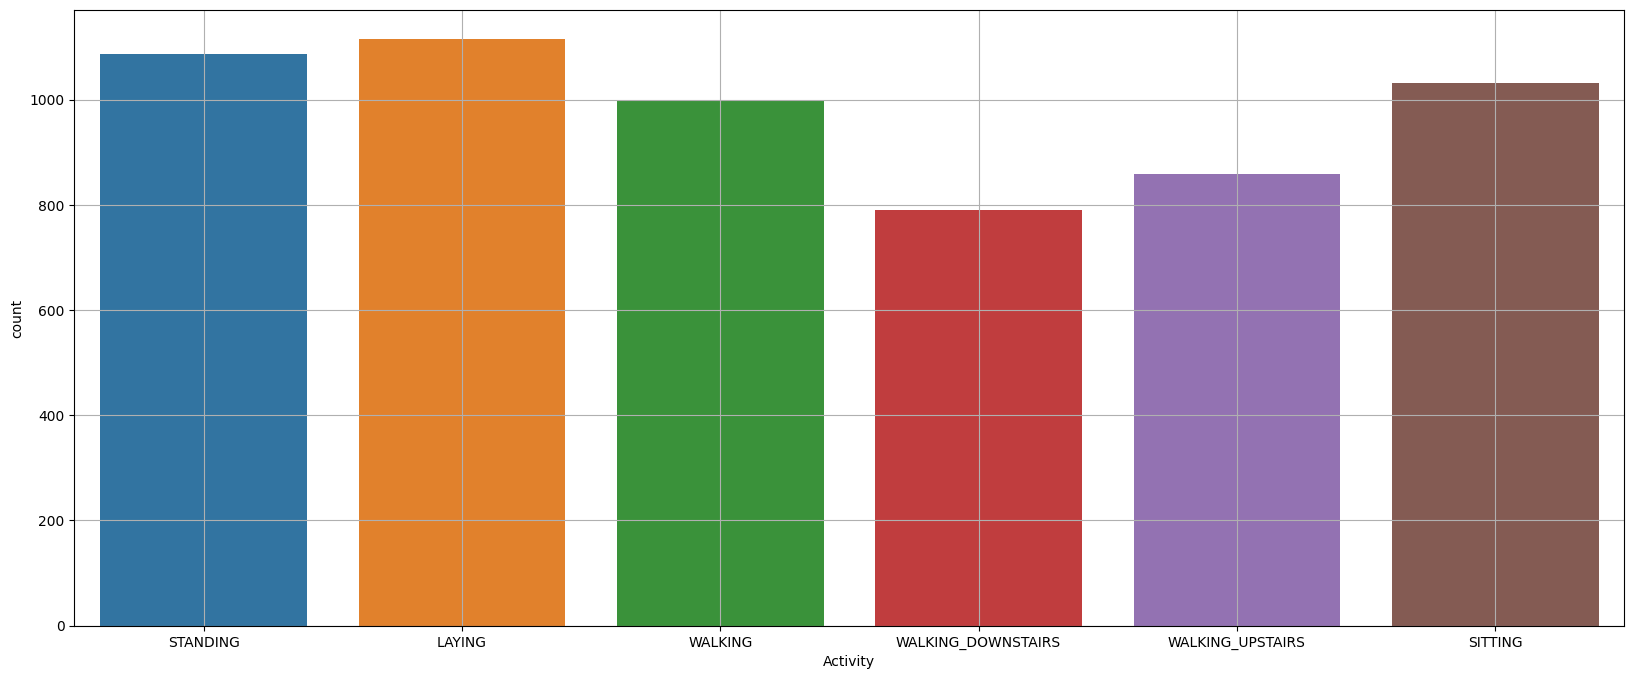

In [34]:
var = 'Activity'
data[var].describe()
def eda1_c(data = data, var = var) : 
    plt.figure(figsize=(20,8))
    print(data[var].value_counts()) 
    print(data[var].value_counts() / data[var].shape[0]) 
    sns.countplot(x=data[var]) 
    plt.grid() 
    
    plt.show()
    
    
eda1_c()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [39]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)  

In [40]:
# 1단계: 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [41]:
# 2단계: 선언하기
model = DecisionTreeClassifier()

# 3단계: 학습하기
model.fit(x_train, y_train)

# 4단계: 예측하기
y_pred = model.predict(x_test)

# 5단계 평가하기
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[331   0   0   0   0   0]
 [  0 264  28   0   0   0]
 [  0  42 289   0   0   0]
 [  0   0   0 281   6  10]
 [  0   0   0   9 222   8]
 [  0   0   0   7  15 253]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.86      0.90      0.88       292
          STANDING       0.91      0.87      0.89       331
           WALKING       0.95      0.95      0.95       297
WALKING_DOWNSTAIRS       0.91      0.93      0.92       239
  WALKING_UPSTAIRS       0.93      0.92      0.93       275

          accuracy                           0.93      1765
         macro avg       0.93      0.93      0.93      1765
      weighted avg       0.93      0.93      0.93      1765



In [67]:
# 데이터프레임 만들기 
perf_dic = {'feature':list(X), 'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=False, inplace=True)

# 시각화
plt.figure(figsize=(10, 100))
plt.barh(df['feature'], df['importance'])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

In [71]:
new_ft = df[df['importance'] >= 0.001]['feature'].values

In [75]:
new_X = data[new_ft]
new_X.head()

,tGravityAcc-min()-X,fBodyAcc-mad()-X,tGravityAcc-mean()-Y,fBodyAccMag-energy(),"tGravityAcc-arCoeff()-Y,1",tGravityAcc-energy()-Y,"tBodyAcc-correlation()-X,Y","tBodyGyro-correlation()-Y,Z",tGravityAcc-min()-Y,tGravityAccMag-arCoeff()1,...,"tGravityAcc-arCoeff()-Z,4",tBodyAccMag-arCoeff()2,tBodyGyro-entropy()-X,fBodyAcc-skewness()-Z,tBodyAcc-entropy()-X,tBodyAcc-max()-X,fBodyAccMag-mean(),fBodyAccJerk-skewness()-Y,tBodyAccJerkMag-arCoeff()1,"tBodyGyroJerk-arCoeff()-Y,1"
0,0.891969,-0.988021,-0.358842,-0.999653,-0.353349,-0.775936,0.410771,-0.780014,-0.334921,-0.204247,...,0.382783,0.130880,-0.394555,0.122170,-0.273898,-0.929747,-0.985206,-0.342611,0.087878,-0.428046
1,-0.095343,-0.988538,0.924656,-0.999866,-0.056969,0.714508,-0.471294,-0.490318,0.937432,0.191232,...,-0.016493,-0.176711,-0.427161,-0.633812,-0.703003,-0.937337,-0.989450,-0.531897,0.262528,-0.351409
2,0.985606,-0.997419,-0.174095,-0.999897,0.100429,-0.953043,-0.050555,-0.071360,-0.145801,0.468303,...,0.011423,-0.293973,-0.234538,-0.774467,-0.728912,-0.942584,-0.990805,-0.542944,0.375310,0.334204
3,0.943954,-0.146359,-0.297703,-0.850144,-0.290450,-0.849096,-0.004432,0.165821,-0.275699,-0.079123,...,0.464018,-0.013529,0.162849,-0.356883,0.463075,0.008288,-0.407268,-0.263878,0.044754,-0.274961
4,0.901943,0.105888,-0.260540,-0.330888,-0.577442,-0.885215,-0.615754,-0.155413,-0.263482,-0.339126,...,0.798089,0.148867,0.585566,-0.370307,0.297190,0.584131,0.191831,-0.546520,-0.383344,-0.380950


In [76]:
train = new_X.copy()
train['target'] = y

<Axes: xlabel='tGravityAcc-min()-X', ylabel='Density'>

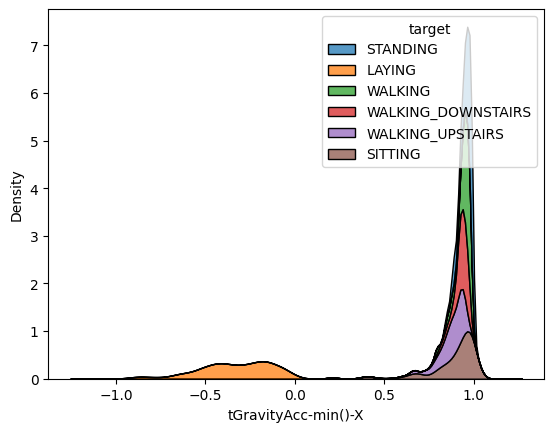

In [78]:
sns.kdeplot(data=train, x="tGravityAcc-min()-X", hue="target", multiple="stack")

In [81]:
train

,tGravityAcc-min()-X,fBodyAcc-mad()-X,tGravityAcc-mean()-Y,fBodyAccMag-energy(),"tGravityAcc-arCoeff()-Y,1",tGravityAcc-energy()-Y,"tBodyAcc-correlation()-X,Y","tBodyGyro-correlation()-Y,Z",tGravityAcc-min()-Y,tGravityAccMag-arCoeff()1,...,tBodyAccMag-arCoeff()2,tBodyGyro-entropy()-X,fBodyAcc-skewness()-Z,tBodyAcc-entropy()-X,tBodyAcc-max()-X,fBodyAccMag-mean(),fBodyAccJerk-skewness()-Y,tBodyAccJerkMag-arCoeff()1,"tBodyGyroJerk-arCoeff()-Y,1",target
0,0.891969,-0.988021,-0.358842,-0.999653,-0.353349,-0.775936,0.410771,-0.780014,-0.334921,-0.204247,...,0.130880,-0.394555,0.122170,-0.273898,-0.929747,-0.985206,-0.342611,0.087878,-0.428046,STANDING
1,-0.095343,-0.988538,0.924656,-0.999866,-0.056969,0.714508,-0.471294,-0.490318,0.937432,0.191232,...,-0.176711,-0.427161,-0.633812,-0.703003,-0.937337,-0.989450,-0.531897,0.262528,-0.351409,LAYING
2,0.985606,-0.997419,-0.174095,-0.999897,0.100429,-0.953043,-0.050555,-0.071360,-0.145801,0.468303,...,-0.293973,-0.234538,-0.774467,-0.728912,-0.942584,-0.990805,-0.542944,0.375310,0.334204,STANDING
3,0.943954,-0.146359,-0.297703,-0.850144,-0.290450,-0.849096,-0.004432,0.165821,-0.275699,-0.079123,...,-0.013529,0.162849,-0.356883,0.463075,0.008288,-0.407268,-0.263878,0.044754,-0.274961,WALKING
4,0.901943,0.105888,-0.260540,-0.330888,-0.577442,-0.885215,-0.615754,-0.155413,-0.263482,-0.339126,...,0.148867,0.585566,-0.370307,0.297190,0.584131,0.191831,-0.546520,-0.383344,-0.380950,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.992398,-0.993514,-0.044093,-0.998690,-0.518016,-0.998616,-0.199868,0.521874,-0.027374,-0.189318,...,0.040638,-0.123716,0.557010,-0.572400,-0.936219,-0.973183,-0.350535,0.327952,-0.328224,SITTING
5877,0.921001,0.013892,-0.317517,-0.719266,-0.216413,-0.826961,-0.294781,-0.334370,-0.291398,-0.391386,...,0.285724,-0.397132,0.173075,0.372544,0.078644,-0.239409,-0.276300,0.249453,-0.270950,WALKING_UPSTAIRS
5878,-0.465011,-0.990401,0.684910,-0.999891,-0.005114,-0.046641,-0.118892,-0.218454,0.700942,0.356925,...,-0.296084,-0.605100,-0.839161,-0.725492,-0.936099,-0.989778,-0.564050,0.335322,0.399783,LAYING
5879,0.932387,-0.022763,-0.302780,-0.690162,-0.452944,-0.843467,-0.251215,0.031608,-0.293450,-0.461286,...,0.428556,0.377211,-0.055955,0.098014,0.219814,-0.265055,-0.404206,-0.486078,-0.252746,WALKING_UPSTAIRS


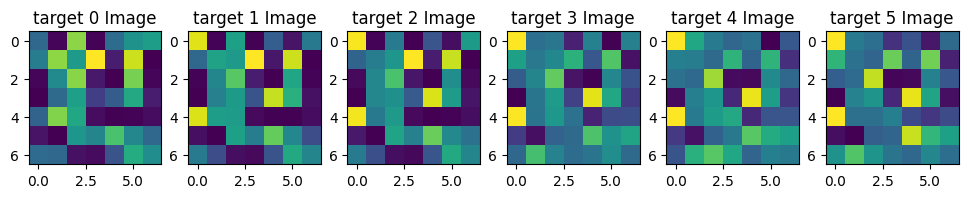

In [84]:
gr_mu2 = train.groupby('target').mean()#.iloc[:, 1 :]
gr_mu2

f, a = plt.subplots(1, 6, figsize = (12, 12))
for i in range(6) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu2.iloc[i]).reshape(7, 7))

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [87]:
data['is_dynamic'] = data['Activity'].apply(lambda x : 0 if x == 'STANDING' or x == 'SITTING' or x == 'LAYING' else 1)

#### 2) 기본모델 생성

In [88]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(X, data['is_dynamic'], test_size=0.3, random_state=1)  

In [89]:
# 1단계: 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [90]:
# 2단계: 선언하기
model = DecisionTreeClassifier()

# 3단계: 학습하기
model.fit(x_train, y_train)

# 4단계: 예측하기
y_pred = model.predict(x_test)

# 5단계 평가하기
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[952   2]
 [  0 811]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석

In [91]:
# 데이터프레임 만들기 
perf_dic = {'feature':list(X), 'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=False, inplace=True)

# 시각화
plt.figure(figsize=(10, 100))
plt.barh(df['feature'], df['importance'])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [92]:
df

,feature,importance
381,"fBodyAccJerk-bandsEnergy()-1,8",0.999017
268,fBodyAcc-std()-X,0.000983
0,tBodyAcc-mean()-X,0.000000
375,fBodyAccJerk-skewness()-X,0.000000
370,fBodyAccJerk-maxInds-Y,0.000000
...,...,...
180,tBodyGyroJerk-iqr()-Y,0.000000
179,tBodyGyroJerk-iqr()-X,0.000000
178,tBodyGyroJerk-energy()-Z,0.000000
177,tBodyGyroJerk-energy()-Y,0.000000


#### 4) feature 그룹별 분석

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.